## Soybean Yield (BU/Acre) Modeling 

### Rahul Zalkikar | rz1567@nyu.edu

A Quantitative Approach

#### Cell Hide Function

#### Imports

In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
from sklearn import metrics, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

#### Import our Data

Our merged dataset contains yearly state feature data representing soil condition, weather and moisture, and geospatial data related to the planting and harvesting of soybean, along with the yield (our target variable) and production value metrics.

This data was primarly compiled through the USDA (soybean related data) and NOAA (climate and weather related data) via API and manual download.

Values of -99.0 represent an instance of no data, and NaN values represent an NA data value.

In [2]:
#proj_dir = os.getcwd()+'\\OneDrive\\Pictures\\Documents\\DS-GA1001-Repo\\Veggie-Tales\\final_repo\\' # connact to our repo
#merged_df = pd.read_csv(proj_dir+'dat\\Processed_Outputs_NA_UPDATE2\\SOIL_DATA_MERGED.csv') # load our data

merged_df = pd.read_csv('../final_repo/dat/Processed_Outputs_NA_UPDATE2/SOIL_DATA_MERGED.csv')

In [3]:
merged_df.head()

YEAR  LOCATION  STATE_ANSI  AREA_OPERATED_IN_ACRES  \
0  1996   ALABAMA           1               9700000.0   
1  1996  ARKANSAS           5              14900000.0   
2  1996  DELAWARE          10                590000.0   
3  1996   FLORIDA          12              10700000.0   
4  1996   GEORGIA          13              11400000.0   

   AREA_OPERATED_IN_ACRES_/_OPERATION  OPERATIONS_IN_OPERATIONS  \
0                                 198                     49000   
1                                 301                     49500   
2                                 211                      2800   
3                                 238                     45000   
4                                 233                     49000   

   AREA_HARVESTED_IN_ACRES  AREA_PLANTED_IN_ACRES  PRODUCTION_IN_BU  \
0                 305000.0               320000.0        10370000.0   
1                3600000.0              3650000.0       109800000.0   
2                 217000.0               220000.0         7595000.0   
3                  45000.0                47000.0         1125000.0   
4                 380000.0               400000.0         7980000.0   

   YIELD_IN_BU_/_ACRE  PRODUCTION_IN_$  PRICE_RECEIVED_IN_$_/_BU  \
0                34.0       76738000.0                      7.40   
1                30.5      755424000.0                      7.36   
2                35.0       54684000.0                      7.20   
3                25.0        7875000.0                      7.00   
4                21.0       53306000.0                      6.87   

   CONDITION_IN_PCT_VERY_POOR  CONDITION_IN_PCT_GOOD  CONDITION_IN_PCT_FAIR  \
0                         1.0                   63.0                   22.0   
1                         3.0                   42.5                   28.5   
2                       -99.0                  -99.0                  -99.0   
3                       -99.0                  -99.0                  -99.0   
4                         2.0                   49.0                   30.0   

   CONDITION_IN_PCT_POOR  CONDITION_IN_PCT_EXCELLENT  \
0                    2.0                         9.5   
1                   12.0                        14.0   
2                  -99.0                       -99.0   
3                  -99.0                       -99.0   
4                    7.0                         6.5   

   CONDITION_5_YEAR_AVG_IN_PCT_EXCELLENT  CONDITION_5_YEAR_AVG_IN_PCT_GOOD  \
0                                    NaN                               NaN   
1                                    NaN                               NaN   
2                                  -99.0                             -99.0   
3                                  -99.0                             -99.0   
4                                    NaN                               NaN   

   CONDITION_5_YEAR_AVG_IN_PCT_POOR  CONDITION_5_YEAR_AVG_IN_PCT_VERY_POOR  \
0                               NaN                                    NaN   
1                               NaN                                    NaN   
2                             -99.0                                  -99.0   
3                             -99.0                                  -99.0   
4                               NaN                                    NaN   

   CONDITION_5_YEAR_AVG_IN_PCT_FAIR  CONDITION_PREVIOUS_YEAR_IN_PCT_POOR  \
0                               NaN                                  NaN   
1                               NaN                                  NaN   
2                             -99.0                                -99.0   
3                             -99.0                                -99.0   
4                               NaN                                  NaN   

   CONDITION_PREVIOUS_YEAR_IN_PCT_GOOD  \
0                                  NaN   
1                                  NaN   
2                                -99.0   
3                                -99.0   
4   

In [4]:
merged_df.shape

(722, 1281)

#### Data Processing

#### Data Processing

We have 1281 features and 722 data points.

First we have to group by state, sort by year, and then lag features measured after Yield in BU per Acre, features that wouldn't be known at the moment of soybean planting in a real-life predictive use case.

We will also leverage lagged Yield in BU per Acre as a feature.

Then we will fill NaN values with 0s as they likely represent no instances of a given feature, and -99.0 values with NaNs before linearly interpolating and extrpolating their values (across both directions).

Finally, we will drop feature columns that represent the same information on a different scale since our goal is to build a  real predictive model that can generalize well (ex. lagged yield and lagged production value, or state and area planted).

In [5]:
print("Number of NaN vals:",merged_df.isna().sum().sum())
merged_df = merged_df.fillna(0)
merged_df = merged_df.replace(-99.0,np.NaN)
print("Number of -99 vals:",merged_df.isna().sum().sum())

Number of NaN vals: 13715
Number of -99 vals: 4989


In [6]:
cols_to_lag = ['YIELD_IN_BU_/_ACRE','PRODUCTION_IN_BU','PRODUCTION_IN_$',
              'PRICE_RECEIVED_IN_$_/_BU','Crop Moisture Stress Index (CMSI)']

weather_cols = ['AVG_TEMP_Month','MAX_TEMP_Month','MIN_TEMP_Month','Precipitation_Month','PDSI_Month','PMDI_Month',
                'Z_index_Month','PHDI_Month']
counter = 0
for col in weather_cols:
    for i in range(4,13):
        cols_to_lag.append(col+str(i))
        
print("Number of columns to lag:",len(cols_to_lag))

Number of columns to lag: 77


In [7]:
final_df = pd.DataFrame()
for _,g in merged_df.groupby('LOCATION'):
    g.sort_values('YEAR',ascending=True)
    for col in cols_to_lag:
        g[col+'_lagged'] = g[col].shift(1)
        if col != 'YIELD_IN_BU_/_ACRE':
            del g[col]
    final_df = final_df.append(g)

/Users/noahkasmanoff/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [8]:
# Lagging a good number of features requires us to drop the year 1996 prior to linear interpolation/extrapolation. 
final_df = final_df[final_df.YEAR != 1996] 
# 2019 was almost entirely extrapolated so we remove it.
final_df = final_df[final_df.YEAR != 2019] 

In [9]:
#Interpolate/Extrapolate -99.0 values (which are now NaN values)
mis_cols = [col for col in final_df.columns if final_df[col].isna().any()]
for col in mis_cols:
    final_df[col] = final_df[col].interpolate(method='linear', axis=0, limit=None, 
                                              inplace=False, limit_direction='both', 
                                              limit_area=None, downcast=None)

In [10]:
# Drop features that include repetitive information
final_df = final_df.drop(['YIELD_IN_BU_/_ACRE_lagged','PRODUCTION_IN_BU_lagged',
                          'PRODUCTION_IN_$_lagged','PRICE_RECEIVED_IN_$_/_BU_lagged',
                          'STATE_ANSI','LOCATION','AREA_OPERATED_IN_ACRES',
                          'OPERATIONS_IN_OPERATIONS','AREA_HARVESTED_IN_ACRES',
                          'CONDITION_IN_PCT_EXCELLENT','CONDITION_IN_PCT_FAIR',
                          'CONDITION_IN_PCT_GOOD','CONDITION_IN_PCT_POOR',
                          'CONDITION_IN_PCT_VERY_POOR'],axis=1)

In [11]:
# Many columns are populated with 0s and therefore have 0 standard deviation. We want to drop these columns
for col in final_df.columns: 
    if final_df[col].std()==0:
        del final_df[col]

number of unique discrete yield vals: 86
number of yield data vals: 678


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1c2a95d0>]],
      dtype=object)

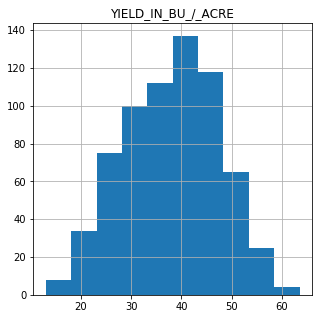

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
cols_to_hist = ['YIELD_IN_BU_/_ACRE'] # range from 12 - 63.5 
print("number of unique discrete yield vals:",len(list(set(final_df['YIELD_IN_BU_/_ACRE']))))
print("number of yield data vals:",len(list(final_df['YIELD_IN_BU_/_ACRE'])))
hist = final_df[cols_to_hist].hist(figsize=(5,5))
hist



To illustrate our model's ability to forecast the most recent year's yield per state, which is our intended use case, we now segment our final dataframe into a training and validation set (includes data from 1997 to 2017) and a testing set (includes 2018 data).

In [13]:
# there might be columns with all 0 values in our test / train set since we split by a year
test_df = final_df.loc[final_df.YEAR == 2018] 
train_val_df = final_df.loc[final_df.YEAR != 2018]

In [14]:
# we finally drop YEAR since our model should be time independent
final_df = final_df.drop(['YEAR'],axis=1)
test_df = test_df.drop(['YEAR'],axis=1)
train_val_df = train_val_df.drop(['YEAR'],axis=1)

In [15]:
# confirm shape consistency
print(test_df.shape, train_val_df.shape, final_df.shape)

(31, 792) (647, 792) (678, 792)


In [16]:
train_val_df.head()

,AREA_OPERATED_IN_ACRES_/_OPERATION,AREA_PLANTED_IN_ACRES,YIELD_IN_BU_/_ACRE,CONDITION_5_YEAR_AVG_IN_PCT_EXCELLENT,CONDITION_5_YEAR_AVG_IN_PCT_GOOD,CONDITION_5_YEAR_AVG_IN_PCT_POOR,CONDITION_5_YEAR_AVG_IN_PCT_VERY_POOR,CONDITION_5_YEAR_AVG_IN_PCT_FAIR,CONDITION_PREVIOUS_YEAR_IN_PCT_POOR,CONDITION_PREVIOUS_YEAR_IN_PCT_GOOD,CONDITION_PREVIOUS_YEAR_IN_PCT_VERY_POOR,CONDITION_PREVIOUS_YEAR_IN_PCT_EXCELLENT,CONDITION_PREVIOUS_YEAR_IN_PCT_FAIR,AVG_TEMP_Month1,AVG_TEMP_Month2,AVG_TEMP_Month3,MAX_TEMP_Month1,MAX_TEMP_Month2,MAX_TEMP_Month3,MIN_TEMP_Month1,MIN_TEMP_Month2,MIN_TEMP_Month3,Precipitation_Month1,Precipitation_Month2,Precipitation_Month3,PDSI_Month1,PDSI_Month2,PDSI_Month3,PMDI_Month1,PMDI_Month2,PMDI_Month3,Z_index_Month1,Z_index_Month2,Z_index_Month3,PHDI_Month1,PHDI_Month2,PHDI_Month3,NITROGEN,PHOSPHATE,POTASH,SULFUR,APPLICATIONS_IN_LB_FERTILIZER_NITROGEN,APPLICATIONS_IN_LB_FERTILIZER_PHOSPHATE,APPLICATIONS_IN_LB_FERTILIZER_POTASH,APPLICATIONS_IN_LB_FERTILIZER_SULFUR,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FERTILIZER_NITROGEN,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FERTILIZER_PHOSPHATE,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FERTILIZER_POTASH,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FERTILIZER_SULFUR,APPLICATIONS_IN_LB_/_ACRE_/_YEAR_AVG_FERTILIZER_NITROGEN,APPLICATIONS_IN_LB_/_ACRE_/_YEAR_AVG_FERTILIZER_PHOSPHATE,APPLICATIONS_IN_LB_/_ACRE_/_YEAR_AVG_FERTILIZER_POTASH,APPLICATIONS_IN_LB_/_ACRE_/_YEAR_AVG_FERTILIZER_SULFUR,APPLICATIONS_IN_NUMBER_AVG_FERTILIZER_NITROGEN,APPLICATIONS_IN_NUMBER_AVG_FERTILIZER_PHOSPHATE,APPLICATIONS_IN_NUMBER_AVG_FERTILIZER_POTASH,APPLICATIONS_IN_NUMBER_AVG_FERTILIZER_SULFUR,TREATED_IN_PCT_OF_AREA_PLANTED_AVG_FERTILIZER_NITROGEN,TREATED_IN_PCT_OF_AREA_PLANTED_AVG_FERTILIZER_PHOSPHATE,TREATED_IN_PCT_OF_AREA_PLANTED_AVG_FERTILIZER_POTASH,TREATED_IN_PCT_OF_AREA_PLANTED_AVG_FERTILIZER_SULFUR,AZOXYSTROBIN,PYRACLOSTROBIN,PROPICONAZOLE,TRIFLOXYSTROBIN,TEBUCONAZOLE,FLUXAPYROXAD,PROTHIOCONAZOLE,FLUAZINAM,TETRACONAZOLE,MYCLOBUTANIL,FLUOXASTROBIN,THIOPHANATE-METHYL,METCONAZOLE,CHLOROTHALONIL,DIFENOCONAZOLE,PICOXYSTROBIN,CYPROCONAZOLE,FLUOPYRAM,MONO-POTASSIUM SALT,BOSCALID,MEFENOXAM,BENZOVINDIFLUPYR,CONIOTHYRIUM MINITAN,BORAX DECAHYDRATE,ISOFETAMID,SEDAXANE,FLUDIOXONIL,FENHEXAMID,BACILLUS PUMILUS,MANCOZEB,ZOXAMIDE,STREPTOMYCES LYDICUS,CYPRODINIL,COPPER CHLORIDE HYD.,BASIC COPPER SULFATE,APPLICATIONS_IN_LB_FUNGICIDE_AZOXYSTROBIN,APPLICATIONS_IN_LB_FUNGICIDE_PYRACLOSTROBIN,APPLICATIONS_IN_LB_FUNGICIDE_PROPICONAZOLE,APPLICATIONS_IN_LB_FUNGICIDE_TRIFLOXYSTROBIN,APPLICATIONS_IN_LB_FUNGICIDE_TEBUCONAZOLE,APPLICATIONS_IN_LB_FUNGICIDE_FLUXAPYROXAD,APPLICATIONS_IN_LB_FUNGICIDE_PROTHIOCONAZOLE,APPLICATIONS_IN_LB_FUNGICIDE_TETRACONAZOLE,APPLICATIONS_IN_LB_FUNGICIDE_CHLOROTHALONIL,APPLICATIONS_IN_LB_FUNGICIDE_DIFENOCONAZOLE,APPLICATIONS_IN_LB_FUNGICIDE_PICOXYSTROBIN,APPLICATIONS_IN_LB_FUNGICIDE_CYPROCONAZOLE,APPLICATIONS_IN_LB_FUNGICIDE_BENZOVINDIFLUPYR,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FUNGICIDE_AZOXYSTROBIN,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FUNGICIDE_PYRACLOSTROBIN,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FUNGICIDE_PROPICONAZOLE,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FUNGICIDE_TRIFLOXYSTROBIN,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FUNGICIDE_TEBUCONAZOLE,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FUNGICIDE_FLUXAPYROXAD,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FUNGICIDE_PROTHIOCONAZOLE,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FUNGICIDE_TETRACONAZOLE,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FUNGICIDE_CHLOROTHALONIL,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FUNGICIDE_DIFENOCONAZOLE,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FUNGICIDE_PICOXYSTROBIN,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FUNGICIDE_CYPROCONAZOLE,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FUNGICIDE_BENZOVINDIFLUPYR,APPLICATIONS_IN_LB_/_ACRE_/_YEAR_AVG_FUNGICIDE_AZOXYSTROBIN,APPLICATIONS_IN_LB_/_ACRE_/_YEAR_AVG_FUNGICIDE_PYRACLOSTROBIN,APPLICATIONS_IN_LB_/_ACRE_/_YEAR_AVG_FUNGICIDE_PROPICONA

In [17]:
# none of our features are highly correlated with yield besides yield itself
corr_df = pd.DataFrame(pd.DataFrame(train_val_df.corr())['YIELD_IN_BU_/_ACRE'].sort_values())
corr_df.reset_index(level=0, inplace=True)
high_cors = []
high_cors.append(corr_df['index'].loc[corr_df['YIELD_IN_BU_/_ACRE'] > 0.5])
high_cors.append(corr_df['index'].loc[corr_df['YIELD_IN_BU_/_ACRE'] < -0.5])
print("Corr > 0.5 with Yield:")
print(str(high_cors[0]))
print(str(high_cors[1]))


Corr > 0.5 with Yield:
742    YIELD_IN_BU_/_ACRE
Name: index, dtype: object
Series([], Name: index, dtype: object)


With a correlation matrix, you are examining unconditional (crude) associations between your variables. With any regression model, you are examining the joint associations of your IVs with your DVs, thus looking at conditional associations (for each IV, its association with the DV conditional on the other IVs). 

#### Feature Selection

We seperate the training/validation set (1997-2017 data) into a feature set and target set

In [18]:
target = ['YIELD_IN_BU_/_ACRE']
X = train_val_df.drop(target,axis=1)
y = train_val_df[target].values.reshape(-1)

We randomly split our feature and target sets into testing and training (20% test 80% train)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
print("Train/Val Data Shape: ",train_val_df.shape) # all columns
print("Random Split Train/Valid Feature Data Shape: ",X_train.shape,X_test.shape) # don't have yield
print("Random Split Train/Valid Yield Data Shape: ",y_train.shape,y_test.shape) # only include yield

Train/Val Data Shape:  (647, 792)
Random Split Train/Valid Feature Data Shape:  (517, 791) (130, 791)
Random Split Train/Valid Yield Data Shape:  (517,) (130,)


In [21]:
def mean_absolute_percentage_error(y_test, y_pred): 
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

In [22]:
def reg_metrics(y_test,y_pred):
    print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_pred),2))  
    print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred),2))  
    print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),2))

In [23]:
def all_metrics(y_test,y_preds):
    print("r-squared:",round(r2_score(y_test,y_preds),2))
    print("MAPE:",round(mean_absolute_percentage_error(y_test,y_preds),2))
    reg_metrics(y_test,y_preds)

In [24]:
def plot_preds_exp(y_preds,y_true):
    plt.scatter(y_preds,y_true)
    min_plot = int(min(min(y_preds),min(y_true)))
    max_plot = int(max(max(y_preds),max(y_true)))
    plt.plot(range(min_plot,max_plot),range(min_plot,max_plot))
    plt.xlabel('Predicted',fontsize=20)
    plt.ylabel('Truth',fontsize=20)
    plt.grid()


In [25]:
def feature_importance(X, clf,feat_import:bool):
    feats = {}
    if feat_import==False:
        for feature, importance in zip(X.columns, clf.coef_):
            feats[feature] = importance #add the name/value pair 
    else:
        for feature, importance in zip(X.columns, clf.feature_importances_):
            feats[feature] = importance
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
    top_features = importances.sort_values(by='Importance')
    return top_features

Standardizing the features around the center and 0 with a standard deviation of 1 is important when we compare measurements that have different units. Variables that are measured at different scales do not contribute equally to the analysis and might end up creating a bais.

Lasso regression puts constraints on the size of the coefficients associated to each variable.
It is therefore necessary to center and reduce, or standardize, the variables.

In [26]:
std_fit = StandardScaler().fit(X_train)
X_train = std_fit.transform(X_train)
X_test = std_fit.transform(X_test)

In [27]:
# 2018 
X_2018 = test_df.drop(target,axis=1)
X_2018 = std_fit.transform(X_2018)
y_2018 = test_df[target].values.reshape(-1)

(array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1]),
 <a list of 11 Text yticklabel objects>)

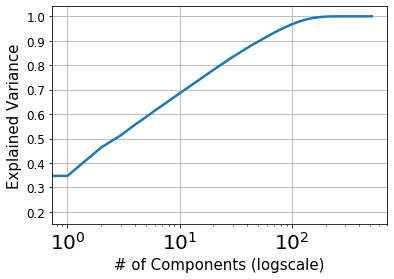

In [28]:
# feature variance chart 
pca = PCA(n_components=min(X_train.shape[0],X_train.shape[1]))
pca = pca.fit(normalize(X_train)) # have to normalize prior to any PCA
plt.plot(np.cumsum(pca.explained_variance_ratio_),linewidth = 2.5)
plt.xlabel('# of Components (logscale)',fontsize  = 15)
plt.ylabel('Explained Variance',fontsize = 15)
plt.grid()
plt.xscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=12)

Now we are motivated to perform feature selection (Lasso, LassoCV, RF)

In [51]:
#Lasso_model = LassoCV(cv=5,tol=0.005,random_state=42)#linear_model.Lasso() #default
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor

Lasso_model = GradientBoostingRegressor()

Lasso_model.fit(X_train,y_train)
train_preds_Lasso = Lasso_model.predict(X_train)
valid_preds_Lasso = Lasso_model.predict(X_test)
test_preds_Lasso = Lasso_model.predict(X_2018)

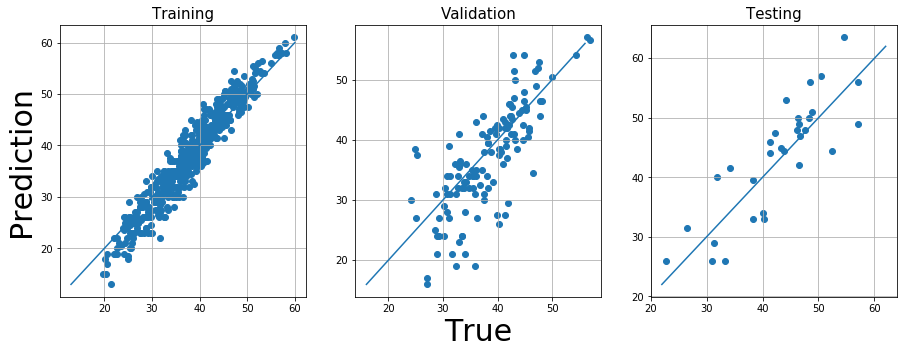

In [52]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title("Training",fontsize=15)
plt.scatter(train_preds_Lasso,y_train)
min_plot = int(min(min(train_preds_Lasso),min(y_train)))
max_plot = int(max(max(train_preds_Lasso),max(y_train)))
plt.plot(range(min_plot,max_plot),range(min_plot,max_plot))
plt.ylabel('Prediction',fontsize=30)
plt.grid()
plt.subplot(132)
plt.title("Validation",fontsize=15)
plt.scatter(valid_preds_Lasso,y_test)
min_plot = int(min(min(valid_preds_Lasso),min(y_test)))
max_plot = int(max(max(valid_preds_Lasso),max(y_test)))
plt.plot(range(min_plot,max_plot),range(min_plot,max_plot))
plt.xlabel('True',fontsize=30)
plt.grid()

plt.subplot(133)
plt.title("Testing",fontsize=15)

plt.scatter(test_preds_Lasso,y_2018)
min_plot = int(min(min(test_preds_Lasso),min(y_2018)))
max_plot = int(max(max(test_preds_Lasso),max(y_2018)))
plt.plot(range(min_plot,max_plot),range(min_plot,max_plot))

plt.grid()



In [35]:
#print("Training:")
plt.subplot(131)
plot_preds_exp(train_preds_Lasso,y_train)
#print("Validation:")
plt.subplot(123)
plot_preds_expvalid_preds_Lasso,y_test)
#print("Testing (2018):")
plt.subplot(133)
plot_preds_exp(test_preds_Lasso,y_2018)


#plt.plot(train_preds_Lasso,y_train,label = 'train')

ValueError: num must be 1 <= num <= 1, not 3

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(train_preds_Lasso,train_preds_Lasso - y_train,'go',alpha=0.4,label = 'Training')
plt.plot(valid_preds_Lasso,valid_preds_Lasso - y_test,'bo',alpha=0.7,label = 'Validation')
plt.plot(test_preds_Lasso,test_preds_Lasso - y_2018,'ro',alpha=0.7,label = 'Testing')
plt.grid()
plt.legend()
plt.xlabel('Yield (BU / AC)',fontsize = 20)
plt.ylabel('Residual',fontsize = 20)

Repeat for RF

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor

Lasso_model = RandomForestRegressor()
Lasso_model.fit(X_train,y_train)
train_preds_Lasso = Lasso_model.predict(X_train)
valid_preds_Lasso = Lasso_model.predict(X_test)
test_preds_Lasso = Lasso_model.predict(X_2018)

In [ ]:
plt.plot(train_preds_Lasso,train_preds_Lasso - y_train,'go',alpha=0.4,label = 'Training')
plt.plot(valid_preds_Lasso,valid_preds_Lasso - y_test,'bo',alpha=0.7,label = 'Validation')
plt.plot(test_preds_Lasso,test_preds_Lasso - y_2018,'ro',alpha=0.7,label = 'Testing')
plt.grid()
plt.legend()
plt.xlabel('Yield (BU / AC)',fontsize = 20)
plt.ylabel('Residual',fontsize = 20)

In [ ]:
Lasso_model.score(X_train,y_train)

In [ ]:
Lasso_cols = feature_importance(X,Lasso_model,False)

In [ ]:
Lasso_cols.T

In [ ]:
print(Lasso_cols.head(5))
print(Lasso_cols.tail(5))
hide_toggle()

Time for the lasso linear model with iterative fitting along a regularization path.
Since it provides sparse solutions, it is generally the model of choice (or some variant of this concept) for modelling cases for sparse data. In such a case, getting a sparse solution is of great computational advantage as the features with zero coefficients can simply be ignored.
The best model is selected by cross-validation.
The optimization objective for Lasso is:

$(1 / (2 * n_{samples})) * ||y - Xw||^2_2 + alpha * ||w||_1$

We will use SelectFromModel meta-transformer along with Lasso to select the best couple of features

In [ ]:
# We use the base estimator LassoCV since the L1 norm promotes sparsity of features.
lassocv_clf = LassoCV(cv=5,tol=0.005,random_state=42)
# tolerance was so small that the optimization never reached a lower value.
#The tolerance for the optimization: if the updates are smaller than tol, the optimization code checks the dual gap for optimality and continues until it is smaller than tol.
sfm_lassocv = SelectFromModel(lassocv_clf)
sfm_lassocv.fit(X_train, y_train)

In [ ]:
print(sfm_lassocv.transform(X_train).shape) # selected 82 columns

In [ ]:
estimator_coefs = sfm.estimator_.coef_
top_features_inds = estimator_coefs.argsort()[-82:][::-1]  # top 82 features
top_82_features_sorted = itemgetter(top_features_inds)(X.columns)
for item in top_82_features_sorted: print(item)
hide_toggle()

In [ ]:
lassocv_clf.fit(X_train, y_train)

In [ ]:
print("RAN ON ALL DATA")
print("Best alpha using built-in LassoCV: %f" %lassocv_clf.alpha_)
print("Best score using built-in LassoCV: %f" %lassocv_clf.score(X_train,y_train))
coef = pd.Series(lassocv_clf.coef_, index = X.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
train_preds_lassocv = lassocv_clf.predict(X_train)
valid_preds_lassocv = lassocv_clf.predict(X_test)
test_preds_lassocv = lassocv_clf.predict(X_t)
print("\nTraining:")
all_metrics(y_train,train_preds_lassocv)
print("\nValidation:")
all_metrics(y_test,valid_preds_lassocv)
print("\nTesting (2018):")
all_metrics(y_t,test_preds_lassocv)
hide_toggle()

In [ ]:
# Our LASSOCV (82 features) selected data
X_train_transformed = sfm.transform(X_train)
X_valid_transformed = sfm.transform(X_test)
X_test_transformed = sfm.transform(X_t)
print(X_train_transformed.shape,X_test_transformed.shape,X_test_transformed.shape)

In [ ]:
lassocv_clf = LassoCV(cv=5,tol=0.005,random_state=42)
lassocv_clf.fit(X_train_transformed, y_train)

In [ ]:
print("RAN ON 82 FEATURES")
print("Best alpha using built-in LassoCV: %f" %lassocv_clf.alpha_)
print("Best score using built-in LassoCV: %f" %lassocv_clf.score(X_train_transformed,y_train))
coef = pd.Series(lassocv_clf.coef_, index = top_82_features_sorted)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
train_preds_lassocv = lassocv_clf.predict(X_train_transformed)
valid_preds_lassocv = lassocv_clf.predict(X_valid_transformed)
test_preds_lassocv = lassocv_clf.predict(X_test_transformed)
print("\nTraining:")
all_metrics(y_train,train_preds_lassocv)
print("\nValidation:")
all_metrics(y_test,valid_preds_lassocv)
print("\nTesting (2018):")
all_metrics(y_t,test_preds_lassocv)
hide_toggle()

In [ ]:
rfr_clf = RandomForestRegressor(random_state=0)
rfr_clf.fit(X_train, y_train)

In [ ]:
rfr_feats = feature_importance(X,rfr_clf,True)
rfr_feats.tail(15)

In [ ]:
print("DEFAULT RANDOM FOREST REGRESSOR - RAN ON ALL FEATURES")
print("Best score using built-in RF: %f" %rfr_clf.score(X_train,y_train))
train_preds_rfr = rfr_clf.predict(X_train)
valid_preds_rfr = rfr_clf.predict(X_test)
test_preds_rfr = rfr_clf.predict(X_t)
print("\nTraining:")
all_metrics(y_train,train_preds_rfr)
print("\nValidation:")
all_metrics(y_test,valid_preds_rfr)
print("\nTesting (2018):")
all_metrics(y_t,test_preds_rfr)
hide_toggle()

In [ ]:
rfr_clf = RandomForestRegressor(random_state=0)
rfr_clf.fit(X_train_transformed, y_train)

In [ ]:
print("DEFAULT RANDOM FOREST REGRESSOR - RAN ON 82 FEATURES (from LassoCV)")
print("Best score using built-in RF: %f" %rfr_clf.score(X_train_transformed,y_train))
train_preds_rfr = rfr_clf.predict(X_train_transformed)
valid_preds_rfr = rfr_clf.predict(X_valid_transformed)
test_preds_rfr = rfr_clf.predict(X_test_transformed)
print("\nTraining:")
all_metrics(y_train,train_preds_rfr)
print("\nValidation:")
all_metrics(y_test,valid_preds_rfr)
print("\nTesting (2018):")
all_metrics(y_t,test_preds_rfr)
hide_toggle()

In [ ]:
# common top features from default random forest and default lasso cv
common_top_features = set(list(rfr_feats.tail(82).index)) & set(list(top_82_features_sorted))
list(common_top_features)

In [ ]:
X_train_common = X[list(common_top_features)]
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_train_common, y, test_size=0.2, random_state=42)
rfr_clf = RandomForestRegressor(random_state=0)
rfr_clf.fit(X_train_2, y_train_2)

In [ ]:
print("DEFAULT RANDOM FOREST REGRESSOR - RAN ON COMMON TOP FEATURES (from LassoCV and RF)")
print("Best score using built-in RF: %f" %rfr_clf.score(X_train_2,y_train))
train_preds_rfr = rfr_clf.predict(X_train_2)
valid_preds_rfr = rfr_clf.predict(X_test_2)
print("\nTraining:")
all_metrics(y_train,train_preds_rfr)
print("\nValidation:")
all_metrics(y_test,valid_preds_rfr)

Random forests select, at each candidate split in the decision tree learning process, a random subset of the features. Without feature bagging, if one or a few features are really strong predictors for yield per acre it is likely they will be present in many of the decision trees created, increasing the correlation between estimators and causing learners to be biased in favor of  features that appear highly predictive in the training set, but fail to be as predictive for unseen data points. 

Random forests are a way of averaging multiple deep decision trees, trained on different parts of the same training set, with the goal of reducing the variance with the cost of increased bias. 

Our first model is going to be a Random Forest Regressor via sklearn.

We leverage randomized search for optimizing our hyperparameters. All parameters that influence the learning are searched simultaneously (except for the number of estimators, which poses a time / quality tradeoff).

In [ ]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [ ]:
# A parameter grid for XGBoost
#Tune tree-specific parameters first
xgb_params = {
        'n_estimators': [int(x) for x in np.linspace(start = 1, stop = 100, num = 10)],
        'max_features': ['auto', 'sqrt'], # num features to consider at each split
        'min_child_weight': [1, 5, 10],
        '''
        Defines the minimum sum of weights of all observations required in a child.
        This is similar to min_child_leaf in GBM but not exactly. 
        This refers to min “sum of weights” of observations while GBM has min “number of observations”.
        Used to control over-fitting. 
        Higher values prevent a model from learning relations which might be highly specific 
        to the particular sample selected for a tree.
        Too high values can lead to under-fitting hence, it should be tuned using CV.
        '''
        'gamma': [0.5, 1, 1.5, 2, 5],
        '''
        A node is split only when the resulting split gives a positive reduction in the loss function. 
        Gamma specifies the minimum loss reduction required to make a split.
        Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
        '''
        'subsample': [0.6, 0.8, 1.0],
        ''' 
        Denotes the fraction of observations to be randomly samples for each tree.
        Lower values make the algorithm more conservative and prevents overfitting 
        but too small values might lead to under-fitting.
        '''
        'colsample_bytree': [0.6, 0.8, 1.0],
        '''
        Denotes the fraction of columns to be randomly samples for each tree.
        '''
        'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)], # max num levels in tree
        '''
        Used to control over-fitting as higher depth will allow model to 
        learn relations very specific to a particular sample.
        '''
        'min_samples_split': [2, 5, 10], # min samples for a node split
        'min_samples_leaf': [1, 2, 4], # min samples at each leaf node
        'bootstrap': [True, False] # how to sample
        }
'''
xgb_reg_params = {
        'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
        #L1 regularization term on weights. 
        #Increasing this value will make model more conservative. Normalised to number of training examples.
        #'reg_lambda':[]
        }
'''
xgb_tune_params = {
        'learning_rate':[0.0025,0.005,0.0075,0.01,0.02]
        }
rfr_params = {
        'n_estimators': [int(x) for x in np.linspace(start = 1, stop = 100, num = 10)],
        'max_features': ['auto', 'sqrt'], # num features to consider at each split
        'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)], # max num levels in tree
        'min_samples_split': [2, 5, 10], # min samples for a node split
        'min_samples_leaf': [1, 2, 4], # min samples at each leaf node
        'bootstrap': [True, False] # how to sample
        }

In [ ]:
xgb = XGBRegressor(objective='reg:squarederror', #Linear regression uses (y - y_pred)^2 as the Cost Function
                    booster='gbtree',
                    silent=False, nthread=3) # 3 cores available

In [ ]:
print(rfr)
print(xgb)

In [ ]:
param_comb = 100 #how many different combinations should be picked randomly out of our total - this should be relatively high

In [ ]:
random_search_rfr = RandomizedSearchCV(rfr, param_distributions=rfr_params, 
                                   n_iter=param_comb, scoring='neg_mean_squared_error', 
                                   n_jobs=4, cv=5, verbose=3, random_state=42)

random_search_xgb = RandomizedSearchCV(xgb, param_distributions=xgb_params, 
                                   n_iter=param_comb, scoring='neg_mean_squared_error', 
                                   n_jobs=4, cv=5, verbose=3, random_state=42)

Tuned Random Forest for all features and for subset of features

In [ ]:
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search_rfr.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

In [ ]:
random_search_rfr.best_params_

In [ ]:
print("TUNED RF FOR ALL DATA -----\n")
rfr_train_preds_tuned_all = random_search_rfr.predict(X_train)
print("TRAINING:\n")
all_metrics(y_train,rfr_train_preds_tuned_all)

rfr_valid_preds_tuned_all = random_search_rfr.predict(X_test)
print("VALIDATION:\n")
all_metrics(y_test,rfr_valid_preds_tuned_all)

rfr_test_preds_tuned_all = random_search_rfr.predict(X_t)
print("\nTESTING:\n")
all_metrics(y_t,rfr_test_preds_tuned_all)

In [ ]:
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search_rfr.fit(X_train_transformed, y_train)
timer(start_time) # timing ends here for "start_time" variable

In [ ]:
random_search_rfr.best_params_

In [ ]:
print("TUNED RF FOR SUBSET OF DATA -----\n")
rfr_train_preds_tuned_sub = random_search_rfr.predict(X_train_transformed)
print("TRAINING:\n")
all_metrics(y_train,rfr_train_preds_tuned_sub)

rfr_valid_preds_tuned_sub = random_search_rfr.predict(X_valid_transformed)
print("\nVALIDATION:\n")
all_metrics(y_test,rfr_valid_preds_tuned_sub)

rfr_test_preds_tuned_sub = random_search_rfr.predict(X_test_transformed)
print("\nTESTING:\n")
all_metrics(y_t,rfr_test_preds_tuned_sub)

Tuned XGBooster for all features and subset of features

In [ ]:
start_time = timer(None)
random_search_xgb.fit(X_train, y_train)
timer(start_time) 

In [ ]:
random_search_xgb.best_params_

In [ ]:
print("FIRST TUNING XGB FOR ALL DATA -----\n")
xgb_train_preds_first_all = random_search_xgb.predict(X_train)
print("TRAINING:\n")
all_metrics(y_train,xgb_train_preds_first_all)

xgb_valid_preds_first_all = random_search_xgb.predict(X_test)
print("VALIDATION:\n")
all_metrics(y_test,xgb_valid_preds_first_all)

xgb_test_preds_first_all = random_search_xgb.predict(X_t)
print("\nTESTING:\n")
all_metrics(y_t,xgb_test_preds_first_all)

In [ ]:
# lower our learning rate for final tuning
xgb2 = XGBRegressor(objective='reg:squarederror', #Linear regression uses (y - y_pred)^2 as the Cost Function
                    booster='gbtree',
                   learning_rate = 0.075,
                    n_estimators =  100,
                    min_samples_leaf= 1,
                    min_child_weight=1,
                    max_features='auto',
                    colsample_bytree= 1.0,
                    min_samples_split= 10,
                    max_depth= 20,
                    gamma=5,
                    subsample=0.8,
                    bootstrap= False,
                    silent=False, nthread=3) # 3 cores available

In [ ]:
start_time = timer(None)
xgb2.fit(X_train, y_train)
timer(start_time) 

In [ ]:
print("SECOND TUNING XGB FOR ALL DATA -----\n")
xgb_train_preds_s_all = xgb2.predict(X_train)
print("TRAINING:\n")
all_metrics(y_train,xgb_train_preds_s_all)

xgb_valid_preds_s_all = xgb2.predict(X_test)
print("VALIDATION:\n")
all_metrics(y_test,xgb_valid_preds_s_all)

xgb_test_preds_s_all = xgb2.predict(X_t)
print("\nTESTING:\n")
all_metrics(y_t,xgb_test_preds_s_all)

In [ ]:
start_time = timer(None)
random_search_xgb.fit(X_train_transformed, y_train)
timer(start_time) 

In [ ]:
random_search_xgb.best_params_

In [ ]:
print("FIRST TUNING XGB FOR SUBSET OF DATA -----\n")
xgb_train_preds_first_sub = random_search_xgb.predict(X_train_transformed)
print("TRAINING:\n")
all_metrics(y_train,xgb_train_preds_first_sub)

xgb_valid_preds_first_sub = random_search_xgb.predict(X_valid_transformed)
print("VALIDATION:\n")
all_metrics(y_test,xgb_valid_preds_first_sub)

xgb_test_preds_first_sub = random_search_xgb.predict(X_test_transformed)
print("\nTESTING:\n")
all_metrics(y_t,xgb_test_preds_first_sub)

In [ ]:
# lower our learning rate for final tuning
xgb_sub2 = XGBRegressor(objective='reg:squarederror', #Linear regression uses (y - y_pred)^2 as the Cost Function
                    booster='gbtree',
                   learning_rate = 0.075,
                    n_estimators =  100,
                    min_samples_leaf= 1,
                    min_child_weight=1,
                    max_features='auto',
                    colsample_bytree= 1.0,
                    min_samples_split= 10,
                    max_depth= 20,
                    gamma=5,
                    subsample=0.8,
                    bootstrap= False,
                    silent=False, nthread=3) # 3 cores available

In [ ]:
start_time = timer(None)
xgb_sub2.fit(X_train_transformed, y_train)
timer(start_time) 

In [ ]:
print("SECOND TUNING XGB FOR SUBSET OF DATA -----\n")
xgb_train_preds_s_sub = xgb_sub2.predict(X_train_transformed)
print("TRAINING:\n")
all_metrics(y_train,xgb_train_preds_s_sub)

xgb_valid_preds_s_sub = xgb_sub2.predict(X_valid_transformed)
print("VALIDATION:\n")
all_metrics(y_test,xgb_valid_preds_s_sub)

xgb_test_preds_s_sub = xgb_sub2.predict(X_test_transformed)
print("\nTESTING:\n")
all_metrics(y_t,xgb_test_preds_s_sub)

Classification is actually performing amazingly. might not have time but its interesting

In [ ]:
# doesnt seem like theres a point to svr if baseline rbf kernel performance is worse than our xgb and rf
for c in list([0.001,0.01,0.1,1,10]):
    for g in list([0.001,0.01,0.1,1,10]):
        svr = svm.SVR(kernel='rbf',C=c,gamma=g)
        svr_val_preds_all = svr.fit(normalize(X_train),y_train).predict(normalize(X_test))
        print("C",c," G",g)
        all_metrics(y_test,svr_val_preds_all)